In [7]:
%load_ext autoreload
%autoreload 2
from glob import glob
import os
import re
import sys
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename
from func.ml_utils import display_importance
from sklearn.metrics import roc_auc_score


COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMN_GROUP = 'DT-M'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, COLUMN_GROUP, 'is_train', 'date']

#========================================================================
# bear
#========================================================================
bear = pd.read_csv('../input/20190913_ieee__bear_probing.csv').iloc[:, [0, 3, 4, 6]]
bear = bear[bear[COLUMN_TARGET]==-1]
bear = bear.iloc[:, [0,1,3]]
bear.columns = [COLUMN_ID, 'data_type', COLUMN_TARGET]
submission = pd.read_csv('../input/sample_submission.csv')
submission.columns = [COLUMN_ID, 'pred']


def bear_validation(test_pred):
    submission['pred'] = test_pred
    bear_score = submission.merge(bear, how='inner', on=COLUMN_ID)
    public  = bear_score[bear_score['data_type']=='test_public']
    private = bear_score[bear_score['data_type']=='test_private']
    
    public_score = roc_auc_score(public[COLUMN_TARGET].values, public['pred'].values)
    private_score = roc_auc_score(private[COLUMN_TARGET].values, private['pred'].values)
    all_score = roc_auc_score(bear_score[COLUMN_TARGET].values, bear_score['pred'].values)

    return public_score, private_score, all_score

def valid_submit_prediction(prediction):
    """Summary line.
    他Submit Prediction Valueとの相関をチェック
    Args:
    
    Returns:
    """
    list_submit_path = sorted(glob('../submit/validation/*.csv'))
    list_submit = []
    
    print("* Check Corr with Past Submit.")
    for path in list_submit_path:
        lb_score = re.search(rf'([^/LB]*).csv', path).group(1)
        submit = pd.read_csv(path)
        submit.sort_values(by=COLUMN_ID, inplace=True)
        submit = submit.iloc[:, 1].values
        
        print('  * ', prediction.shape, submit.shape)
        corr = np.min(np.corrcoef(prediction, submit))
        print(f"  * LB{lb_score} / {corr}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#========================================================================
# Bear's
#========================================================================

lb9577 = pd.read_csv('../submit/lb/20190921_2310__CV0-95542686.csv').iloc[:, 1]
lb9565 = pd.read_csv('../submit/lb/20190920_1351__re__CV0-95346_lr0-05.csv').iloc[:, 1]

valid_submit_prediction(lb9577)
valid_submit_prediction(lb9565)

print(bear_validation(lb9577))
print(bear_validation(lb9565))

* Check Corr with Past Submit.
  *  (506691,) (506691,)
  * LB0.9515 / 0.9457493107520403
  *  (506691,) (506691,)
  * LB0.9545 / 0.9562889762270239
  *  (506691,) (506691,)
  * LB0.9561 / 0.9297066819946653
* Check Corr with Past Submit.
  *  (506691,) (506691,)
  * LB0.9515 / 0.9424969209959528
  *  (506691,) (506691,)
  * LB0.9545 / 0.9552249366014728
  *  (506691,) (506691,)
  * LB0.9561 / 0.9202610579559067
(0.9748869699881121, 0.9733443789930146, 0.9740759221663995)
(0.9836538472957711, 0.9783842170445813, 0.980336875187371)


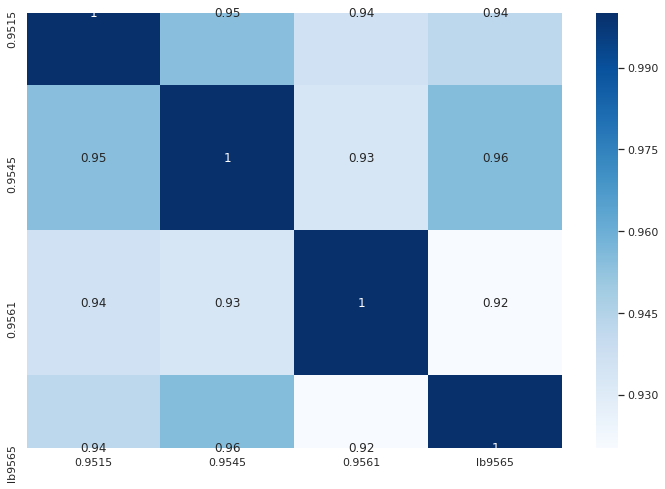

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)


#========================================================================
# Corr
#========================================================================

sub = pd.read_csv('../submit/lb/20190920_1351__re__CV0-95346_lr0-05.csv').sort_values(by=COLUMN_ID)
sub.columns = [COLUMN_ID, 'lb9565']
list_submit_path = sorted(glob('../submit/validation/*.csv'))

for path in list_submit_path:
    lb_score = re.search(rf'([^/LB]*).csv', path).group(1)
    sub[lb_score] = pd.read_csv(path).sort_values(by=COLUMN_ID)[COLUMN_TARGET].values

sub.set_index(COLUMN_ID, inplace=True)
sub = sub[sorted(sub.columns)]
plt.figure(figsize=(12, 8))

sns.heatmap(sub.corr(), annot=True, cmap='Blues')
plt.show()

In [6]:
# pred9516 = sub9516[COLUMN_TARGET].values
# pred9519 = sub9519[COLUMN_TARGET].values
# pred9550 = sub9550[COLUMN_TARGET].values
# pred9550_2 = sub9550_2[COLUMN_TARGET].values
# pred9550_3 = sub9550_3[COLUMN_TARGET].values
# print(bear_validation(pred9516))
# print(bear_validation(pred9519))
# print(bear_validation(pred9550))
# print(bear_validation(pred9550_2))
# print(bear_validation(pred9550_3))
# print("="*20)

# blend1 = pred9516*0.2 + pred9519*0.3 + pred9550*0.5
# blend2 = pred9516*0.2 + pred9519*0.2 + pred9550*0.3 + pred9550_2*0.3
# blend3 = pred9516*0.2 + pred9519*0.2 + pred9550*0.25 + pred9550_2*0.25 + pred9550_2*0.1
# print(bear_validation(blend1))
# print(bear_validation(blend2))
# print(bear_validation(blend3))
# valid_submit_prediction(blend1)
# valid_submit_prediction(blend2)
# valid_submit_prediction(blend3)
# valid_submit_prediction(pred9550)

pred = sub950_1.iloc[:, 1].values
print(bear_validation(pred))
valid_submit_prediction(pred)

(0.9836538472957711, 0.9783842170445813, 0.980336875187371)
* Check Corr with Past Submit.
  *  (506691,) (506691,)
  * LB0.9516 / 0.924200225611533
  *  (506691,) (506691,)
  * LB0.95169 / 0.9719078963943651
  *  (506691,) (506691,)
  * LB0.9518 / 0.9546663601131359
  *  (506691,) (506691,)
  * LB0.9529 / 0.9480290623066864
  *  (506691,) (506691,)
  * LB0.9542 / 0.9103771137684395


In [43]:
submission.columns = [COLUMN_ID, COLUMN_TARGET]
submission[COLUMN_TARGET] = blend2
submission.head()

,TransactionID,isFraud
0,3663549,0.000283
1,3663550,0.000620
2,3663551,0.000376
3,3663552,0.000660
4,3663553,0.000384


In [45]:
submission.to_csv('../submit/lb/20190918_0750__CV0-94872__lr0-01_esr100_nl255.csv', index=False)